C:\Users\Asus\AppData\Local\Temp\ipykernel_18076\2636518625.py:15: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  seattle['DATE'] = pd.to_datetime(seattle['DATE'], errors='coerce')


Saved line graph to: ..\Reports\seattle_vs_neworleans_line.png


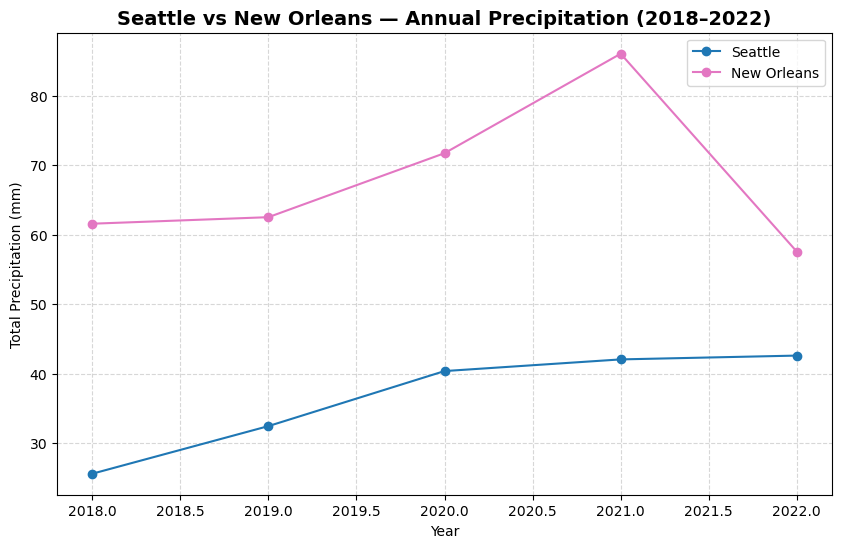

In [50]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Paths (adjust if your data is somewhere else)
data_dir = os.path.join("..", "Data")
seattle_fp = os.path.join(data_dir, "seattle_rain.csv")
neworleans_fp = os.path.join(data_dir, "neworleans_rain.csv")

# Load data
seattle = pd.read_csv(seattle_fp)
neworleans = pd.read_csv(neworleans_fp)

# Convert DATE to datetime
seattle['DATE'] = pd.to_datetime(seattle['DATE'], errors='coerce')
neworleans['DATE'] = pd.to_datetime(neworleans['DATE'], errors='coerce')

# Extract Year
seattle['Year'] = seattle['DATE'].dt.year
neworleans['Year'] = neworleans['DATE'].dt.year

# Filter only 2018–2022
seattle = seattle[(seattle['Year'] >= 2018) & (seattle['Year'] <= 2022)]
neworleans = neworleans[(neworleans['Year'] >= 2018) & (neworleans['Year'] <= 2022)]

# Compute yearly totals
sea_yearly = seattle.groupby('Year')['PRCP'].sum().reset_index()
no_yearly = neworleans.groupby('Year')['PRCP'].sum().reset_index()

# --- Plot ---
plt.figure(figsize=(10,6))
plt.plot(sea_yearly['Year'], sea_yearly['PRCP'], marker='o', color='#1f77b4', label='Seattle')
plt.plot(no_yearly['Year'], no_yearly['PRCP'], marker='o', color='#e377c2', label='New Orleans')

plt.title("Seattle vs New Orleans — Annual Precipitation (2018–2022)", fontsize=14, weight='bold')
plt.xlabel("Year")
plt.ylabel("Total Precipitation (mm)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()

# Save plot
reports_dir = os.path.join("..", "Reports")
os.makedirs(reports_dir, exist_ok=True)
outpath = os.path.join(reports_dir, "seattle_vs_neworleans_line.png")
plt.savefig(outpath, dpi=300)
print("Saved line graph to:", outpath)

plt.show()

Saved plot to: ..\Reports\seattle_vs_neworleans_bars_tealpink.png


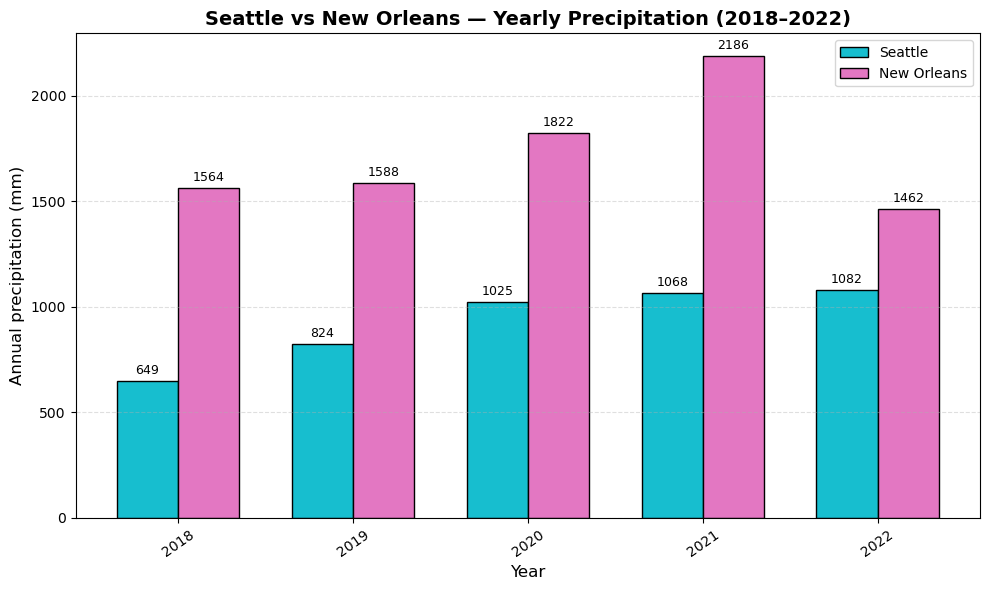

In [51]:
import numpy as np
import matplotlib.pyplot as plt
import os

years = sea_year['Year'].tolist()
sea_vals = sea_year['Seattle_total_mm'].values
no_vals  = no_year['NewOrleans_total_mm'].values

x = np.arange(len(years))
width = 0.35

fig, ax = plt.subplots(figsize=(10,6))

# Solid colors: Teal + Pink
color_sea = '#17becf'   # Teal
color_no  = '#e377c2'   # Pink

bars1 = ax.bar(x - width/2, sea_vals, width, label='Seattle',
               color=color_sea, edgecolor='k')
bars2 = ax.bar(x + width/2, no_vals,  width, label='New Orleans',
               color=color_no, edgecolor='k')

ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Annual precipitation (mm)', fontsize=12)
ax.set_title('Seattle vs New Orleans — Yearly Precipitation (2018–2022)',
             fontsize=14, weight='bold')
ax.set_xticks(x)
ax.set_xticklabels(years, rotation=35)
ax.grid(axis='y', linestyle='--', alpha=0.4)

# Annotate values on bars
def annotate(bars):
    for b in bars:
        h = b.get_height()
        ax.annotate(f"{h:.0f}", xy=(b.get_x()+b.get_width()/2, h),
                    xytext=(0,5), textcoords="offset points",
                    ha='center', fontsize=9)
annotate(bars1)
annotate(bars2)

ax.legend()
plt.tight_layout()

# Save high-resolution image
reports_dir = os.path.join("..","Reports")
os.makedirs(reports_dir, exist_ok=True)
outpath = os.path.join(reports_dir, "seattle_vs_neworleans_bars_tealpink.png")
plt.savefig(outpath, dpi=300)
print("Saved plot to:", outpath)

plt.show()